In [1]:
from datetime import datetime
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import dotenv_values
from sklearn.ensemble import RandomForestClassifier
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', 6)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
from data.preprocessing import DataPreprocessor
from config import get_connection
from data.db import execute_sql, batched_read_notification_sql
from data.notifcation_preparation import *

In [2]:
conf = dotenv_values("../.env")

In [3]:
conn = get_connection(conf)

In [69]:
notifications = batched_read_notification_sql(conn, subset=6)

Running batch id >= 0 and id < 1000
Running batch id >= 1000 and id < 2000
Running batch id >= 2000 and id < 3000
Running batch id >= 3000 and id < 4000
Running batch id >= 4000 and id < 5000
Running batch id >= 5000 and id < 6000


In [115]:
len(notifications)

5969

In [116]:
notifications_list = flat_notifications_from_sql(notifications)

res = prepare_dataset(notifications_list)

In [117]:
res = DataPreprocessor.remove_partial_data(res)

In [118]:
raw = pd.DataFrame(data=res)
df = raw.reindex(sorted(raw.columns), axis=1)
df.shape

(4807, 734)

In [119]:
raw.columns

Index(['id', 'ticker', 'price', 'notification_date', 'highest_since_notified',
       'lowest_since_notified', 'filter_name', 'same_signal_in_last_3_hour',
       'same_signal_in_last_24_hours', 'same_signal_profit_in_last_3_hours',
       ...
       'current_hour_bars_47_open', 'current_hour_bars_47_high',
       'current_hour_bars_47_low', 'current_hour_bars_47_close',
       'current_hour_bars_47_volume', 'current_hour_bars_48_open',
       'current_hour_bars_48_high', 'current_hour_bars_48_low',
       'current_hour_bars_48_close', 'current_hour_bars_48_volume'],
      dtype='object', length=734)

In [120]:
df = DataPreprocessor.remove_corrupt_data(df)
df.shape


(4807, 734)

In [121]:
# remove semi missing data 2022-05-11 to 2022-05-24
df = DataPreprocessor.remove_date_range(df, 
                                        datetime.fromisoformat("2022-05-11"),
                                        datetime.fromisoformat("2022-05-24")
                                        )
df.shape

(4807, 734)

In [122]:
# remove semi missing data 2022-06-30 16:30 to 2022-07-02 11:17
df = DataPreprocessor.remove_date_range(df, 
                                        datetime.fromisoformat("2022-06-30 16:30"),
                                        datetime.fromisoformat("2022-07-02 11:17")
                                        )
df.shape

(4807, 734)

In [123]:
df = DataPreprocessor.remove_most_recent_data(df)
df.shape

(4807, 734)

In [124]:
df = DataPreprocessor.add_regression_label_columns(df)
df.shape

(4807, 736)

In [125]:
df = DataPreprocessor.drop_categorical_features(df)
df.shape

(4807, 703)

In [126]:
#df.select_dtypes(include=['object'])

In [127]:
df = df.drop_duplicates(keep='first')
df.shape

(4045, 703)

In [128]:
df

,btc_stats_statsMap_-10_days_avg1HourVolume,btc_stats_statsMap_-10_days_changeRate,btc_stats_statsMap_-10_days_close,btc_stats_statsMap_-10_days_high,btc_stats_statsMap_-10_days_low,btc_stats_statsMap_-10_days_open,btc_stats_statsMap_-12_hours_avg1HourVolume,btc_stats_statsMap_-12_hours_changeRate,btc_stats_statsMap_-12_hours_close,btc_stats_statsMap_-12_hours_high,btc_stats_statsMap_-12_hours_low,btc_stats_statsMap_-12_hours_open,btc_stats_statsMap_-14_days_avg1HourVolume,btc_stats_statsMap_-14_days_changeRate,btc_stats_statsMap_-14_days_close,btc_stats_statsMap_-14_days_high,btc_stats_statsMap_-14_days_low,btc_stats_statsMap_-14_days_open,btc_stats_statsMap_-20_days_avg1HourVolume,btc_stats_statsMap_-20_days_changeRate,btc_stats_statsMap_-20_days_close,btc_stats_statsMap_-20_days_high,btc_stats_statsMap_-20_days_low,btc_stats_statsMap_-20_days_open,btc_stats_statsMap_-24_hours_avg1HourVolume,btc_stats_statsMap_-24_hours_changeRate,btc_stats_statsMap_-24_hours_close,btc_stats_statsMap_-24_hours_high,btc_stats_statsMap_-24_hours_low,btc_stats_statsMap_-24_hours_open,btc_stats_statsMap_-28_days_avg1HourVolume,btc_stats_statsMap_-28_days_changeRate,btc_stats_statsMap_-28_days_close,btc_stats_statsMap_-28_days_high,btc_stats_statsMap_-28_days_low,btc_stats_statsMap_-28_days_open,btc_stats_statsMap_-3_days_avg1HourVolume,btc_stats_statsMap_-3_days_changeRate,btc_stats_statsMap_-3_days_close,btc_stats_statsMap_-3_days_high,btc_stats_statsMap_-3_days_low,btc_stats_statsMap_-3_days_open,btc_stats_statsMap_-5_days_avg1HourVolume,btc_stats_statsMap_-5_days_changeRate,btc_stats_statsMap_-5_days_close,btc_stats_statsMap_-5_days_high,btc_stats_statsMap_-5_days_low,btc_stats_statsMap_-5_days_open,btc_stats_statsMap_-60_days_avg1HourVolume,btc_stats_statsMap_-60_days_changeRate,btc_stats_statsMap_-60_days_close,btc_stats_statsMap_-60_days_high,btc_stats_statsMap_-60_days_low,btc_stats_statsMap_-60_days_open,btc_stats_statsMap_-6_hours_avg1HourVolume,btc_stats_statsMap_-6_hours_changeRate,btc_stats_statsMap_-6_hours_close,btc_stats_statsMap_-6_hours_high,btc_stats_statsMap_-6_hours_low,btc_stats_statsMap_-6_hours_open,btc_stats_statsMap_-7_days_avg1HourVolume,btc_stats_statsMap_-7_days_changeRate,btc_stats_statsMap_-7_days_close,btc_stats_statsMap_-7_days_high,btc_stats_statsMap_-7_days_low,btc_stats_statsMap_-7_days_open,current_close,current_currentHourlyBarVolume,current_currentMinutelyBarVolume,current_hour_bars_01_close,current_hour_bars_01_high,current_hour_bars_01_low,current_hour_bars_01_open,current_hour_bars_01_volume,current_hour_bars_02_close,current_hour_bars_02_high,current_hour_bars_02_low,current_hour_bars_02_open,current_hour_bars_02_volume,current_hour_bars_03_close,current_hour_bars_03_high,current_hour_bars_03_low,current_hour_bars_03_open,current_hour_bars_03_volume,current_hour_bars_04_close,current_hour_bars_04_high,current_hour_bars_04_low,current_hour_bars_04_open,current_hour_bars_04_volume,current_hour_bars_05_close,current_hour_bars_05_high,current_hour_bars_05_low,current_hour_bars_05_open,current_hour_bars_05_volume,current_hour_bars_06_close,current_hour_bars_06_high,current_hour_bars_06_low,current_hour_bars_06_open,current_hour_bars_06_volume,current_hour_bars_07_close,current_hour_bars_07_high,current_hour_bars_07_low,current_hour_bars_07_open,current_hour_bars_07_volume,current_hour_bars_08_close,current_hour_bars_08_high,current_hour_bars_08_low,current_hour_bars_08_open,current_hour_bars_08_volume,current_hour_bars_09_close,current_hour_bars_09_high,current_hour_bars_09_low,current_hour_bars_09_open,current_hour_bars_09_volume,current_hour_bars_10_close,current_hour_bars_10_high,current_hour_bars_10_low,current_hour_bars_10_open,current_hour_bars_10_volume,current_hour_bars_11_close,current_hour_bars_11_high,current_hour_bars_11_low,current_hour_bars_11_open,current_hour_bars_11_volume,current_hour_bars_12_close,current_hour_bars_12_high,current_hour_bars_12_low,current_hour_bars_12_open,current_hour_bars

In [129]:
# COMMENTED OUT
# drop columns with duplicated values, leave first one
#df = df.loc[:,~df.apply(lambda y: y.duplicated(),axis=1).all()].copy()
#df.shape
#df = DataPreprocessor.select_only_required_features(df)
#df.shape

In [130]:
def current_hourly_bars(col):
    return col.startswith('current_hour_bars') and col.endswith('close') 
            
current_hourly_bars_cols = [col for col in df if current_hourly_bars(col)]

current_hourly_bars_cols = sorted(current_hourly_bars_cols, reverse=True)
current_hourly_bars_cols.append("latest_hour_close")

assert len(current_hourly_bars_cols) == 49
assert current_hourly_bars_cols[-2] == 'current_hour_bars_01_close'

len(current_hourly_bars_cols)

49

In [131]:
# current over -1 hour bar comparison
def add_higher_high_col(df, shift=1):
    DIGIT_PATTERN = r'\d+'
    higher_high_cols = []
    for current, previous in zip(current_hourly_bars_cols[shift:], current_hourly_bars_cols):
        current_numbers = re.findall(DIGIT_PATTERN, current)
        current_number = f'hour_{current_numbers[0]}_close' if current_numbers else current
        previous_numbers = re.findall(DIGIT_PATTERN, previous)
        previous_number = previous_numbers[0] if previous_numbers else previous
        is_higher_col = f'{current_number}_higher_than_{previous_number}'
        df[is_higher_col] = df[current] > df[previous]
        df[is_higher_col] = df[is_higher_col].astype(int) 
        higher_high_cols.append(is_higher_col)
    return higher_high_cols

In [132]:
higher_high_cols_shift_1 = add_higher_high_col(df)
df.loc[:, higher_high_cols_shift_1]

,hour_47_close_higher_than_48,hour_46_close_higher_than_47,hour_45_close_higher_than_46,hour_44_close_higher_than_45,hour_43_close_higher_than_44,hour_42_close_higher_than_43,hour_41_close_higher_than_42,hour_40_close_higher_than_41,hour_39_close_higher_than_40,hour_38_close_higher_than_39,hour_37_close_higher_than_38,hour_36_close_higher_than_37,hour_35_close_higher_than_36,hour_34_close_higher_than_35,hour_33_close_higher_than_34,hour_32_close_higher_than_33,hour_31_close_higher_than_32,hour_30_close_higher_than_31,hour_29_close_higher_than_30,hour_28_close_higher_than_29,hour_27_close_higher_than_28,hour_26_close_higher_than_27,hour_25_close_higher_than_26,hour_24_close_higher_than_25,hour_23_close_higher_than_24,hour_22_close_higher_than_23,hour_21_close_higher_than_22,hour_20_close_higher_than_21,hour_19_close_higher_than_20,hour_18_close_higher_than_19,hour_17_close_higher_than_18,hour_16_close_higher_than_17,hour_15_close_higher_than_16,hour_14_close_higher_than_15,hour_13_close_higher_than_14,hour_12_close_higher_than_13,hour_11_close_higher_than_12,hour_10_close_higher_than_11,hour_09_close_higher_than_10,hour_08_close_higher_than_09,hour_07_close_higher_than_08,hour_06_close_higher_than_07,hour_05_close_higher_than_06,hour_04_close_higher_than_05,hour_03_close_higher_than_04,hour_02_close_higher_than_03,hour_01_close_higher_than_02,latest_hour_close_higher_than_01
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,1,0,0,1,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4802,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,1,1,1,1,1,0,0,0,1,1,0,1,0,1,0,0,1,0,0,1,1,0,1,1,1,1,0,1,1,0,1
4803,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0
4805,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,1,1,0,1,1,1,1,0,0,0,1,0,1,0,1,0,0,1,0


In [133]:
higher_high_cols_shift_5 = add_higher_high_col(df, 5)
df.loc[:, higher_high_cols_shift_5]

,hour_43_close_higher_than_48,hour_42_close_higher_than_47,hour_41_close_higher_than_46,hour_40_close_higher_than_45,hour_39_close_higher_than_44,hour_38_close_higher_than_43,hour_37_close_higher_than_42,hour_36_close_higher_than_41,hour_35_close_higher_than_40,hour_34_close_higher_than_39,hour_33_close_higher_than_38,hour_32_close_higher_than_37,hour_31_close_higher_than_36,hour_30_close_higher_than_35,hour_29_close_higher_than_34,hour_28_close_higher_than_33,hour_27_close_higher_than_32,hour_26_close_higher_than_31,hour_25_close_higher_than_30,hour_24_close_higher_than_29,hour_23_close_higher_than_28,hour_22_close_higher_than_27,hour_21_close_higher_than_26,hour_20_close_higher_than_25,hour_19_close_higher_than_24,hour_18_close_higher_than_23,hour_17_close_higher_than_22,hour_16_close_higher_than_21,hour_15_close_higher_than_20,hour_14_close_higher_than_19,hour_13_close_higher_than_18,hour_12_close_higher_than_17,hour_11_close_higher_than_16,hour_10_close_higher_than_15,hour_09_close_higher_than_14,hour_08_close_higher_than_13,hour_07_close_higher_than_12,hour_06_close_higher_than_11,hour_05_close_higher_than_10,hour_04_close_higher_than_09,hour_03_close_higher_than_08,hour_02_close_higher_than_07,hour_01_close_higher_than_06,latest_hour_close_higher_than_05
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4802,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,1,0,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1
4803,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,1,1,0,1,0,1,1,1
4805,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,1,0,0,1,1


In [134]:
higher_high_cols_shift_10 = add_higher_high_col(df, 10)
df.loc[:, higher_high_cols_shift_10]

,hour_38_close_higher_than_48,hour_37_close_higher_than_47,hour_36_close_higher_than_46,hour_35_close_higher_than_45,hour_34_close_higher_than_44,hour_33_close_higher_than_43,hour_32_close_higher_than_42,hour_31_close_higher_than_41,hour_30_close_higher_than_40,hour_29_close_higher_than_39,hour_28_close_higher_than_38,hour_27_close_higher_than_37,hour_26_close_higher_than_36,hour_25_close_higher_than_35,hour_24_close_higher_than_34,hour_23_close_higher_than_33,hour_22_close_higher_than_32,hour_21_close_higher_than_31,hour_20_close_higher_than_30,hour_19_close_higher_than_29,hour_18_close_higher_than_28,hour_17_close_higher_than_27,hour_16_close_higher_than_26,hour_15_close_higher_than_25,hour_14_close_higher_than_24,hour_13_close_higher_than_23,hour_12_close_higher_than_22,hour_11_close_higher_than_21,hour_10_close_higher_than_20,hour_09_close_higher_than_19,hour_08_close_higher_than_18,hour_07_close_higher_than_17,hour_06_close_higher_than_16,hour_05_close_higher_than_15,hour_04_close_higher_than_14,hour_03_close_higher_than_13,hour_02_close_higher_than_12,hour_01_close_higher_than_11,latest_hour_close_higher_than_10
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4802,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,1,1,1,1,1,1,0,0,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1
4803,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,1,1,1,0,1,1,1
4805,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,1,1,1,0,1,0,0,0,0,1,1


In [135]:
higher_high_cols_shift_20 = add_higher_high_col(df, 20)
df.loc[:, higher_high_cols_shift_20]

,hour_28_close_higher_than_48,hour_27_close_higher_than_47,hour_26_close_higher_than_46,hour_25_close_higher_than_45,hour_24_close_higher_than_44,hour_23_close_higher_than_43,hour_22_close_higher_than_42,hour_21_close_higher_than_41,hour_20_close_higher_than_40,hour_19_close_higher_than_39,hour_18_close_higher_than_38,hour_17_close_higher_than_37,hour_16_close_higher_than_36,hour_15_close_higher_than_35,hour_14_close_higher_than_34,hour_13_close_higher_than_33,hour_12_close_higher_than_32,hour_11_close_higher_than_31,hour_10_close_higher_than_30,hour_09_close_higher_than_29,hour_08_close_higher_than_28,hour_07_close_higher_than_27,hour_06_close_higher_than_26,hour_05_close_higher_than_25,hour_04_close_higher_than_24,hour_03_close_higher_than_23,hour_02_close_higher_than_22,hour_01_close_higher_than_21,latest_hour_close_higher_than_20
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4802,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1
4803,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1
4805,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,1,1


In [136]:
higher_high_cols_shift_40 = add_higher_high_col(df, 40)
df.loc[:, higher_high_cols_shift_40]

,hour_08_close_higher_than_48,hour_07_close_higher_than_47,hour_06_close_higher_than_46,hour_05_close_higher_than_45,hour_04_close_higher_than_44,hour_03_close_higher_than_43,hour_02_close_higher_than_42,hour_01_close_higher_than_41,latest_hour_close_higher_than_40
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
4802,0,0,0,0,0,0,0,0,0
4803,0,0,0,0,0,0,0,0,0
4805,0,0,0,0,0,0,0,0,1


In [137]:
check = higher_high_cols_shift_1 + ['latest_hour_close', 'current_hour_bars_01_close']
df.loc[:, check]


,hour_47_close_higher_than_48,hour_46_close_higher_than_47,hour_45_close_higher_than_46,hour_44_close_higher_than_45,hour_43_close_higher_than_44,hour_42_close_higher_than_43,hour_41_close_higher_than_42,hour_40_close_higher_than_41,hour_39_close_higher_than_40,hour_38_close_higher_than_39,hour_37_close_higher_than_38,hour_36_close_higher_than_37,hour_35_close_higher_than_36,hour_34_close_higher_than_35,hour_33_close_higher_than_34,hour_32_close_higher_than_33,hour_31_close_higher_than_32,hour_30_close_higher_than_31,hour_29_close_higher_than_30,hour_28_close_higher_than_29,hour_27_close_higher_than_28,hour_26_close_higher_than_27,hour_25_close_higher_than_26,hour_24_close_higher_than_25,hour_23_close_higher_than_24,hour_22_close_higher_than_23,hour_21_close_higher_than_22,hour_20_close_higher_than_21,hour_19_close_higher_than_20,hour_18_close_higher_than_19,hour_17_close_higher_than_18,hour_16_close_higher_than_17,hour_15_close_higher_than_16,hour_14_close_higher_than_15,hour_13_close_higher_than_14,hour_12_close_higher_than_13,hour_11_close_higher_than_12,hour_10_close_higher_than_11,hour_09_close_higher_than_10,hour_08_close_higher_than_09,hour_07_close_higher_than_08,hour_06_close_higher_than_07,hour_05_close_higher_than_06,hour_04_close_higher_than_05,hour_03_close_higher_than_04,hour_02_close_higher_than_03,hour_01_close_higher_than_02,latest_hour_close_higher_than_01,latest_hour_close,current_hour_bars_01_close
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,1,0,0,1,0,1,0.37830,0.37280
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0.27760,0.27760
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0.27760,0.27760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4802,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,1,1,1,1,1,0,0,0,1,1,0,1,0,1,0,0,1,0,0,1,1,0,1,1,1,1,0,1,1,0,1,1.25520,1.25250
4803,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,2.64987,2.64987
4805,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,1,1,0,1,1,1,1,0,0,0,1,0,1,0,1,0,0,1,0,0.28570,0.28570


In [138]:
#checks that all cols are not empty even if underlying data is nan
df.loc[:, check].loc[df['current_hour_bars_01_close'].isna()]

,hour_47_close_higher_than_48,hour_46_close_higher_than_47,hour_45_close_higher_than_46,hour_44_close_higher_than_45,hour_43_close_higher_than_44,hour_42_close_higher_than_43,hour_41_close_higher_than_42,hour_40_close_higher_than_41,hour_39_close_higher_than_40,hour_38_close_higher_than_39,hour_37_close_higher_than_38,hour_36_close_higher_than_37,hour_35_close_higher_than_36,hour_34_close_higher_than_35,hour_33_close_higher_than_34,hour_32_close_higher_than_33,hour_31_close_higher_than_32,hour_30_close_higher_than_31,hour_29_close_higher_than_30,hour_28_close_higher_than_29,hour_27_close_higher_than_28,hour_26_close_higher_than_27,hour_25_close_higher_than_26,hour_24_close_higher_than_25,hour_23_close_higher_than_24,hour_22_close_higher_than_23,hour_21_close_higher_than_22,hour_20_close_higher_than_21,hour_19_close_higher_than_20,hour_18_close_higher_than_19,hour_17_close_higher_than_18,hour_16_close_higher_than_17,hour_15_close_higher_than_16,hour_14_close_higher_than_15,hour_13_close_higher_than_14,hour_12_close_higher_than_13,hour_11_close_higher_than_12,hour_10_close_higher_than_11,hour_09_close_higher_than_10,hour_08_close_higher_than_09,hour_07_close_higher_than_08,hour_06_close_higher_than_07,hour_05_close_higher_than_06,hour_04_close_higher_than_05,hour_03_close_higher_than_04,hour_02_close_higher_than_03,hour_01_close_higher_than_02,latest_hour_close_higher_than_01,latest_hour_close,current_hour_bars_01_close
1977,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01467,NaN
1979,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.46160,NaN
1980,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01467,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3348,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.73620,NaN
3358,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.16450,NaN
3408,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.68823,NaN


In [139]:
mask = df['latest_hour_close'] > df['current_hour_bars_01_close']
mask

0        True
1       False
3       False
        ...  
4802     True
4803    False
4805    False
Length: 4045, dtype: bool

In [140]:
df['ema_hour_25'] = df.loc[:, current_hourly_bars_cols].ewm(span=25, ignore_na=True, axis=1).mean()['latest_hour_close']
df['ema_hour_49'] = df.loc[:, current_hourly_bars_cols].ewm(span=49, ignore_na=True, axis=1).mean()['latest_hour_close']
#ewm25
df.loc[:,['ema_hour_25', 'ema_hour_49', 'price']]

,ema_hour_25,ema_hour_49,price
0,0.372085,0.371489,0.38500
1,0.278690,0.278827,0.28960
3,0.278690,0.278827,0.28960
...,...,...,...
4802,1.230117,1.223643,1.28880
4803,2.623622,2.630465,2.70177
4805,0.282491,0.282664,0.29480


In [141]:
current_min_bars_cols = [col for col in df if col.startswith('current_min_bars')]
# should be 60 * 5
assert len(current_min_bars_cols) == 60 * 5
len(current_min_bars_cols)

300

In [142]:
df = df.drop(current_min_bars_cols, axis=1)

In [143]:
current_hourly_bars_partly_cols = [col for col in df if col.startswith('current_hour_bars') and not col.endswith('close') and not col.endswith('volume')]
# should be 48 * 3
assert len(current_hourly_bars_partly_cols) == 48 * 3
len(current_hourly_bars_partly_cols)

144

In [144]:
df = df.drop(current_hourly_bars_partly_cols, axis=1)

In [145]:
history_stats_map__bars_partly_cols = [col for col in df if col.startswith('history_statsMap') 
                                   and not col.endswith('close') 
                                   and not col.endswith('Volume')
                                   and not col.endswith('changeRate')
                                   ]
# should be 48 * 3
#assert len(history_stats_map__bars_partly_cols) == 48 * 3
print(len(history_stats_map__bars_partly_cols))
history_stats_map__bars_partly_cols

30


['history_statsMap_-10_days_high',
 'history_statsMap_-10_days_low',
 'history_statsMap_-10_days_open',
 'history_statsMap_-12_hours_high',
 'history_statsMap_-12_hours_low',
 'history_statsMap_-12_hours_open',
 'history_statsMap_-14_days_high',
 'history_statsMap_-14_days_low',
 'history_statsMap_-14_days_open',
 'history_statsMap_-20_days_high',
 'history_statsMap_-20_days_low',
 'history_statsMap_-20_days_open',
 'history_statsMap_-24_hours_high',
 'history_statsMap_-24_hours_low',
 'history_statsMap_-24_hours_open',
 'history_statsMap_-28_days_high',
 'history_statsMap_-28_days_low',
 'history_statsMap_-28_days_open',
 'history_statsMap_-3_days_high',
 'history_statsMap_-3_days_low',
 'history_statsMap_-3_days_open',
 'history_statsMap_-5_days_high',
 'history_statsMap_-5_days_low',
 'history_statsMap_-5_days_open',
 'history_statsMap_-6_hours_high',
 'history_statsMap_-6_hours_low',
 'history_statsMap_-6_hours_open',
 'history_statsMap_-7_days_high',
 'history_statsMap_-7_days_low

In [146]:
btc_stats_statsMap_bars_partly_cols = [col for col in df if col.startswith('btc_stats_statsMap_') 
                                   and not col.endswith('high') 
                                   and not col.endswith('close') 
                                   and not col.endswith('Volume')
                                   and not col.endswith('changeRate')
                                   ]
# should be 48 * 3
#assert len(btc_stats_statsMap_bars_partly_cols) == 48 * 3
print(len(btc_stats_statsMap_bars_partly_cols))
btc_stats_statsMap_bars_partly_cols

22


['btc_stats_statsMap_-10_days_low',
 'btc_stats_statsMap_-10_days_open',
 'btc_stats_statsMap_-12_hours_low',
 'btc_stats_statsMap_-12_hours_open',
 'btc_stats_statsMap_-14_days_low',
 'btc_stats_statsMap_-14_days_open',
 'btc_stats_statsMap_-20_days_low',
 'btc_stats_statsMap_-20_days_open',
 'btc_stats_statsMap_-24_hours_low',
 'btc_stats_statsMap_-24_hours_open',
 'btc_stats_statsMap_-28_days_low',
 'btc_stats_statsMap_-28_days_open',
 'btc_stats_statsMap_-3_days_low',
 'btc_stats_statsMap_-3_days_open',
 'btc_stats_statsMap_-5_days_low',
 'btc_stats_statsMap_-5_days_open',
 'btc_stats_statsMap_-60_days_low',
 'btc_stats_statsMap_-60_days_open',
 'btc_stats_statsMap_-6_hours_low',
 'btc_stats_statsMap_-6_hours_open',
 'btc_stats_statsMap_-7_days_low',
 'btc_stats_statsMap_-7_days_open']

In [147]:
df = df.drop(btc_stats_statsMap_bars_partly_cols, axis=1)
df.shape

(4045, 408)

In [148]:
df = df.drop(history_stats_map__bars_partly_cols, axis=1)
df.shape

(4045, 378)

In [149]:
highlt_correlated_cols = [
    'btc_stats_statsMap_-10_days_close',
    'btc_stats_statsMap_-12_hours_close',
    'btc_stats_statsMap_-14_days_close',
    'btc_stats_statsMap_-20_days_close',
    'btc_stats_statsMap_-24_hours_close',
    'btc_stats_statsMap_-3_days_close',
    'btc_stats_statsMap_-5_days_close',
    'btc_stats_statsMap_-6_hours_close',
    'btc_stats_statsMap_-7_days_close'	,
    'history_statsMap_-10_days_close',
    'history_statsMap_-12_hours_close',
    'history_statsMap_-14_days_close',
    'history_statsMap_-20_days_close',
    'history_statsMap_-24_hours_close',
    'history_statsMap_-3_days_close',
    'history_statsMap_-5_days_close',
    'history_statsMap_-6_hours_close',
    'history_statsMap_-7_days_close',
    'current_lastMinutelyBar_close',
    'current_previousMinutelyBar_close',
    'current_previousMinutelyBar_high',
    'current_previousMinutelyBar_low',
    'current_previousMinutelyBar_open',
    'current_previousMinutelyBar_volume'
]
df = df.drop(highlt_correlated_cols, axis=1)
df.shape

(4045, 354)

In [150]:
corr_matrix = df.corr().abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)

sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
                  .stack()
                  .sort_values(ascending=False))

#first element of sol series is the pair with the biggest correlation
check_cols = set()
for index, value in sol.items():
    # do some staff
    if value > 0.9:
        #print(index, value)
        for v in index:
            check_cols.add(v)

In [151]:
check_cols = sorted(check_cols)

In [152]:
check_cols

['btc_stats_statsMap_-10_days_avg1HourVolume',
 'btc_stats_statsMap_-10_days_changeRate',
 'btc_stats_statsMap_-10_days_high',
 'btc_stats_statsMap_-12_hours_high',
 'btc_stats_statsMap_-14_days_avg1HourVolume',
 'btc_stats_statsMap_-14_days_high',
 'btc_stats_statsMap_-20_days_changeRate',
 'btc_stats_statsMap_-20_days_high',
 'btc_stats_statsMap_-28_days_avg1HourVolume',
 'btc_stats_statsMap_-28_days_changeRate',
 'btc_stats_statsMap_-28_days_close',
 'btc_stats_statsMap_-3_days_changeRate',
 'btc_stats_statsMap_-3_days_high',
 'btc_stats_statsMap_-5_days_avg1HourVolume',
 'btc_stats_statsMap_-5_days_changeRate',
 'btc_stats_statsMap_-5_days_high',
 'btc_stats_statsMap_-60_days_close',
 'btc_stats_statsMap_-6_hours_high',
 'btc_stats_statsMap_-7_days_avg1HourVolume',
 'btc_stats_statsMap_-7_days_changeRate',
 'btc_stats_statsMap_-7_days_high',
 'current_close',
 'current_currentHourlyBarVolume',
 'current_hour_bars_01_close',
 'current_hour_bars_02_close',
 'current_hour_bars_02_volu

In [154]:
df.loc[:, check_cols]

,btc_stats_statsMap_-10_days_avg1HourVolume,btc_stats_statsMap_-10_days_changeRate,btc_stats_statsMap_-10_days_high,btc_stats_statsMap_-12_hours_high,btc_stats_statsMap_-14_days_avg1HourVolume,btc_stats_statsMap_-14_days_high,btc_stats_statsMap_-20_days_changeRate,btc_stats_statsMap_-20_days_high,btc_stats_statsMap_-28_days_avg1HourVolume,btc_stats_statsMap_-28_days_changeRate,btc_stats_statsMap_-28_days_close,btc_stats_statsMap_-3_days_changeRate,btc_stats_statsMap_-3_days_high,btc_stats_statsMap_-5_days_avg1HourVolume,btc_stats_statsMap_-5_days_changeRate,btc_stats_statsMap_-5_days_high,btc_stats_statsMap_-60_days_close,btc_stats_statsMap_-6_hours_high,btc_stats_statsMap_-7_days_avg1HourVolume,btc_stats_statsMap_-7_days_changeRate,btc_stats_statsMap_-7_days_high,current_close,current_currentHourlyBarVolume,current_hour_bars_01_close,current_hour_bars_02_close,current_hour_bars_02_volume,current_hour_bars_03_close,current_hour_bars_03_volume,current_hour_bars_04_close,current_hour_bars_04_volume,current_hour_bars_05_close,current_hour_bars_05_volume,current_hour_bars_06_close,current_hour_bars_06_volume,current_hour_bars_07_close,current_hour_bars_07_volume,current_hour_bars_08_close,current_hour_bars_08_volume,current_hour_bars_09_close,current_hour_bars_09_volume,current_hour_bars_10_close,current_hour_bars_10_volume,current_hour_bars_11_close,current_hour_bars_11_volume,current_hour_bars_12_close,current_hour_bars_12_volume,current_hour_bars_13_close,current_hour_bars_13_volume,current_hour_bars_14_close,current_hour_bars_14_volume,current_hour_bars_15_close,current_hour_bars_15_volume,current_hour_bars_16_close,current_hour_bars_17_close,current_hour_bars_17_volume,current_hour_bars_18_close,current_hour_bars_18_volume,current_hour_bars_19_close,current_hour_bars_19_volume,current_hour_bars_20_close,current_hour_bars_20_volume,current_hour_bars_21_close,current_hour_bars_21_volume,current_hour_bars_22_close,current_hour_bars_22_volume,current_hour_bars_23_close,current_hour_bars_23_volume,current_hour_bars_24_close,current_hour_bars_24_volume,current_hour_bars_25_close,current_hour_bars_25_volume,current_hour_bars_26_close,current_hour_bars_26_volume,current_hour_bars_27_close,current_hour_bars_27_volume,current_hour_bars_28_close,current_hour_bars_28_volume,current_hour_bars_29_close,current_hour_bars_29_volume,current_hour_bars_30_close,current_hour_bars_30_volume,current_hour_bars_31_close,current_hour_bars_31_volume,current_hour_bars_32_close,current_hour_bars_32_volume,current_hour_bars_33_close,current_hour_bars_33_volume,current_hour_bars_34_close,current_hour_bars_34_volume,current_hour_bars_35_close,current_hour_bars_35_volume,current_hour_bars_36_close,current_hour_bars_36_volume,current_hour_bars_37_close,current_hour_bars_37_volume,current_hour_bars_38_close,current_hour_bars_38_volume,current_hour_bars_39_close,current_hour_bars_39_volume,current_hour_bars_40_close,current_hour_bars_40_volume,current_hour_bars_41_close,current_hour_bars_41_volume,current_hour_bars_42_close,current_hour_bars_42_volume,current_hour_bars_43_close,current_hour_bars_43_volume,current_hour_bars_44_close,current_hour_bars_44_volume,current_hour_bars_45_close,current_hour_bars_45_volume,current_hour_bars_46_close,current_hour_bars_46_volume,current_hour_bars_47_close,current_hour_bars_47_volume,current_hour_bars_48_close,current_hour_bars_48_volume,current_lastMinutelyBar_high,current_lastMinutelyBar_low,current_lastMinutelyBar_open,current_open,current_xinfo_ask,current_xinfo_averagePrice,current_xinfo_bid,current_xinfo_high,current_xinfo_last,current_xinfo_low,current_xinfo_volume,ema_hour_25,ema_hour_49,history_statsMap_-10_days_avg1HourVolume,history_statsMap_-12_hours_avg1HourVolume,history_statsMap_-14_days_avg1HourVolume,history_statsMap_-20_days_avg1HourVolume,history_statsMap_-24_hours_avg1HourVolume,history_statsMap_-28_days_avg1HourVolume,history_statsMap_-28_days_close,history_statsMap_-3_days_avg1HourVolume,history_stats

<AxesSubplot:>

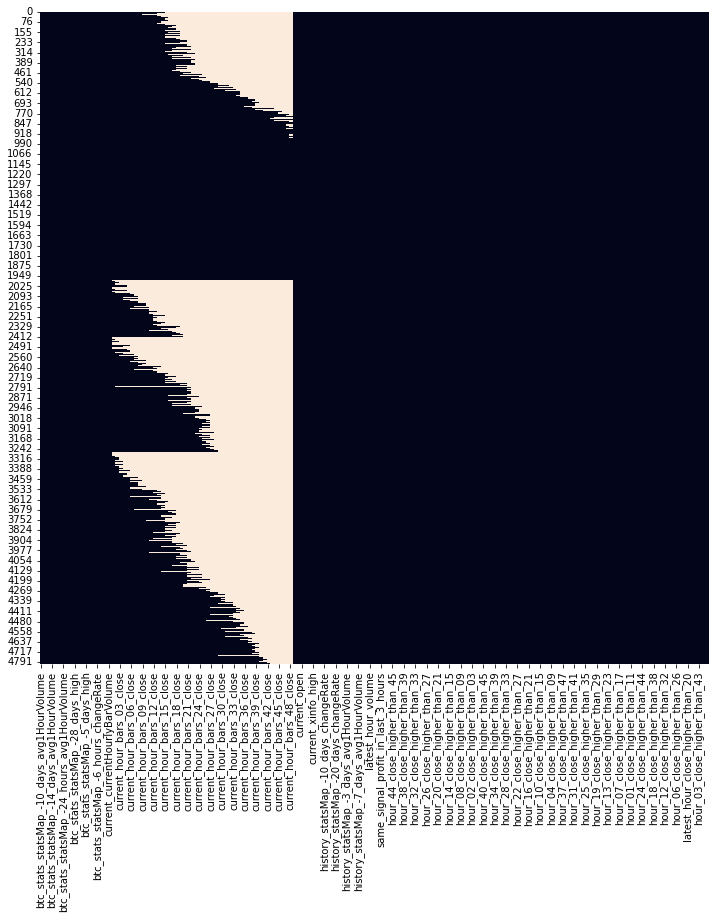

In [155]:
plt.figure(figsize=(12,12))

sns.heatmap(df.isnull(),cbar=False)

In [159]:
df

,btc_stats_statsMap_-10_days_avg1HourVolume,btc_stats_statsMap_-10_days_changeRate,btc_stats_statsMap_-10_days_high,btc_stats_statsMap_-12_hours_avg1HourVolume,btc_stats_statsMap_-12_hours_changeRate,btc_stats_statsMap_-12_hours_high,btc_stats_statsMap_-14_days_avg1HourVolume,btc_stats_statsMap_-14_days_changeRate,btc_stats_statsMap_-14_days_high,btc_stats_statsMap_-20_days_avg1HourVolume,btc_stats_statsMap_-20_days_changeRate,btc_stats_statsMap_-20_days_high,btc_stats_statsMap_-24_hours_avg1HourVolume,btc_stats_statsMap_-24_hours_changeRate,btc_stats_statsMap_-24_hours_high,btc_stats_statsMap_-28_days_avg1HourVolume,btc_stats_statsMap_-28_days_changeRate,btc_stats_statsMap_-28_days_close,btc_stats_statsMap_-28_days_high,btc_stats_statsMap_-3_days_avg1HourVolume,btc_stats_statsMap_-3_days_changeRate,btc_stats_statsMap_-3_days_high,btc_stats_statsMap_-5_days_avg1HourVolume,btc_stats_statsMap_-5_days_changeRate,btc_stats_statsMap_-5_days_high,btc_stats_statsMap_-60_days_avg1HourVolume,btc_stats_statsMap_-60_days_changeRate,btc_stats_statsMap_-60_days_close,btc_stats_statsMap_-60_days_high,btc_stats_statsMap_-6_hours_avg1HourVolume,btc_stats_statsMap_-6_hours_changeRate,btc_stats_statsMap_-6_hours_high,btc_stats_statsMap_-7_days_avg1HourVolume,btc_stats_statsMap_-7_days_changeRate,btc_stats_statsMap_-7_days_high,current_close,current_currentHourlyBarVolume,current_currentMinutelyBarVolume,current_hour_bars_01_close,current_hour_bars_01_volume,current_hour_bars_02_close,current_hour_bars_02_volume,current_hour_bars_03_close,current_hour_bars_03_volume,current_hour_bars_04_close,current_hour_bars_04_volume,current_hour_bars_05_close,current_hour_bars_05_volume,current_hour_bars_06_close,current_hour_bars_06_volume,current_hour_bars_07_close,current_hour_bars_07_volume,current_hour_bars_08_close,current_hour_bars_08_volume,current_hour_bars_09_close,current_hour_bars_09_volume,current_hour_bars_10_close,current_hour_bars_10_volume,current_hour_bars_11_close,current_hour_bars_11_volume,current_hour_bars_12_close,current_hour_bars_12_volume,current_hour_bars_13_close,current_hour_bars_13_volume,current_hour_bars_14_close,current_hour_bars_14_volume,current_hour_bars_15_close,current_hour_bars_15_volume,current_hour_bars_16_close,current_hour_bars_16_volume,current_hour_bars_17_close,current_hour_bars_17_volume,current_hour_bars_18_close,current_hour_bars_18_volume,current_hour_bars_19_close,current_hour_bars_19_volume,current_hour_bars_20_close,current_hour_bars_20_volume,current_hour_bars_21_close,current_hour_bars_21_volume,current_hour_bars_22_close,current_hour_bars_22_volume,current_hour_bars_23_close,current_hour_bars_23_volume,current_hour_bars_24_close,current_hour_bars_24_volume,current_hour_bars_25_close,current_hour_bars_25_volume,current_hour_bars_26_close,current_hour_bars_26_volume,current_hour_bars_27_close,current_hour_bars_27_volume,current_hour_bars_28_close,current_hour_bars_28_volume,current_hour_bars_29_close,current_hour_bars_29_volume,current_hour_bars_30_close,current_hour_bars_30_volume,current_hour_bars_31_close,current_hour_bars_31_volume,current_hour_bars_32_close,current_hour_bars_32_volume,current_hour_bars_33_close,current_hour_bars_33_volume,current_hour_bars_34_close,current_hour_bars_34_volume,current_hour_bars_35_close,current_hour_bars_35_volume,current_hour_bars_36_close,current_hour_bars_36_volume,current_hour_bars_37_close,current_hour_bars_37_volume,current_hour_bars_38_close,current_hour_bars_38_volume,current_hour_bars_39_close,current_hour_bars_39_volume,current_hour_bars_40_close,current_hour_bars_40_volume,current_hour_bars_41_close,current_hour_bars_41_volume,current_hour_bars_42_close,current_hour_bars_42_volume,current_hour_bars_43_close,current_hour_bars_43_volume,current_hour_bars_44_close,current_hour_bars_44_volume,current_hour_bars_45_close,current_hour_bars_45_volume,current_hour_bars_46_close,current_hour_bars_46_volume,current_hour_bars_47_close,current_hour_bars_47_volume,curren

In [160]:
# Initial try, with filling df with 0
df = df.fillna(0)

In [161]:
# if volume is negative - replace with zero
DataPreprocessor.replace_negative_volumes(df)

In [162]:
#already added as 'latest_hour_volume'
#DataPreprocessor.add_current_hour_volume(df)

In [163]:
history_vol_cols = DataPreprocessor.add_current_hour_volume_to_historical_volumes_coef(df)

In [164]:
next(history_vol_cols)

['history_statsMap_-10_days_avg1HourVolume', 'history_statsMap_-12_hours_avg1HourVolume', 'history_statsMap_-14_days_avg1HourVolume', 'history_statsMap_-20_days_avg1HourVolume', 'history_statsMap_-24_hours_avg1HourVolume', 'history_statsMap_-28_days_avg1HourVolume', 'history_statsMap_-3_days_avg1HourVolume', 'history_statsMap_-5_days_avg1HourVolume', 'history_statsMap_-6_hours_avg1HourVolume', 'history_statsMap_-7_days_avg1HourVolume']


['current_h_vol_to_10_days_avg',
 'current_h_vol_to_12_hours_avg',
 'current_h_vol_to_14_days_avg',
 'current_h_vol_to_20_days_avg',
 'current_h_vol_to_24_hours_avg',
 'current_h_vol_to_28_days_avg',
 'current_h_vol_to_3_days_avg',
 'current_h_vol_to_5_days_avg',
 'current_h_vol_to_6_hours_avg',
 'current_h_vol_to_7_days_avg']

In [165]:
# finding corrupt data with excessive volumes, requires categorical features
#df[(df["id"] > 13000) & (df["id"] < 17000)].loc[::, ["id", "notification_date", *next(history_vol_cols)]].nlargest(n=3000, columns=['current_h_vol_to_28_days_avg'], keep='all')

In [166]:
# Which signal made best return?
df[df['label_up_return'] == df['label_up_return'].max()].loc[:, ['price', 'label_up_return']]

,price,label_up_return
4289,0.000151,463.576159


In [167]:
# Which signal made worst return?
df[df['label_down_return'] == df['label_down_return'].min()].loc[:, ['price', 'label_down_return']]

,price,label_down_return
478,0.02591,-40.94944


In [168]:
df_vol = df[[*next(history_vol_cols), 'label_up_return', 'label_down_return']]
x = df_vol.drop(['label_up_return','label_down_return'], 1)

# cleaning outliers in data
df_vol_coef_clean = df_vol[((x > x.quantile(.03)) & (x < x.quantile(.97))).all(1)]
#df_vol_coef_clean = df_vol[(np.abs(stats.zscore(df_vol)) < 4).all(axis=1)]
df_vol_coef_clean.shape

C:\Users\hustlestar\AppData\Local\Temp\ipykernel_2412\2187119051.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x = df_vol.drop(['label_up_return','label_down_return'], 1)


(3233, 12)

<AxesSubplot:>

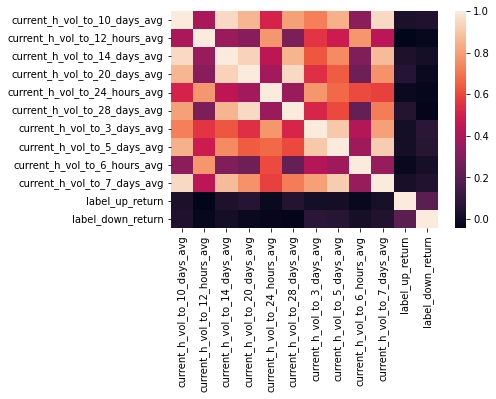

In [169]:
sns.heatmap(df_vol_coef_clean.corr())

In [170]:
df = next(DataPreprocessor.remove_outliers(df, history_vol_cols))
df.shape

D:\Projects\trading-bot-ml\src\data\preprocessing.py:203: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x = df_vol.drop(['label_up_return', 'label_down_return'], 1)


(3747, 364)

In [171]:
# removing those which don't have -3 hours of data
df = DataPreprocessor.remove_rows_with_less_than_3_hours(df)
df.shape

(3530, 364)

In [172]:
df['current_hour_bars_01_volume']

0       388804.671013
1        29733.483404
3        29733.483404
            ...      
4800     15844.453281
4802     15844.453281
4803         0.000000
Name: current_hour_bars_01_volume, Length: 3530, dtype: float64

<AxesSubplot:>

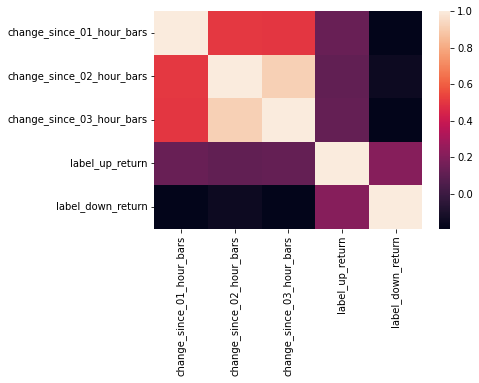

In [173]:
latest_close_cols = ['change_since_01_hour_bars', 'change_since_02_hour_bars', 'change_since_03_hour_bars']
df['change_since_01_hour_bars'] = (df['price'] - df['current_hour_bars_01_close']) / df['current_hour_bars_01_close'] * 100
df['change_since_02_hour_bars'] = (df['price'] - df['current_hour_bars_02_close']) / df['current_hour_bars_02_close'] * 100
df['change_since_03_hour_bars'] = (df['price'] - df['current_hour_bars_03_close']) / df['current_hour_bars_03_close'] * 100
df_change_since_previous = df[[*latest_close_cols, 'label_up_return', 'label_down_return']]
sns.heatmap(df_change_since_previous.corr())

C:\Users\hustlestar\Anaconda3\envs\x-dev\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='change_since_01_hour_bars', ylabel='label_down_return'>

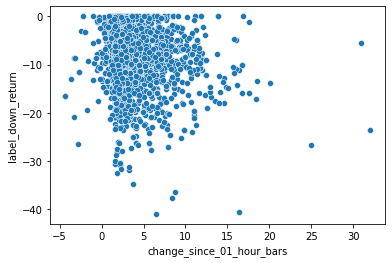

In [174]:
# there is some reverse correlation in change and down return
sns.scatterplot(df['change_since_01_hour_bars'], df['label_down_return'])

<AxesSubplot:>

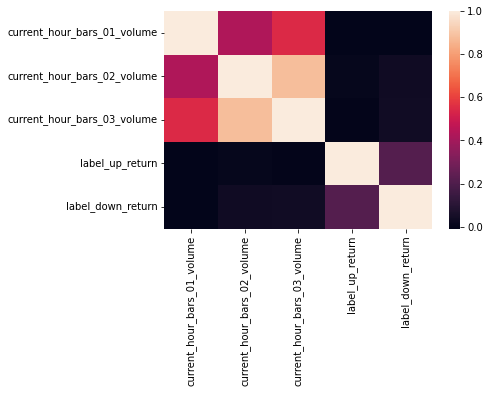

In [175]:
df_volume_on_previous = df[['current_hour_bars_01_volume',
    'current_hour_bars_02_volume',
    'current_hour_bars_03_volume',
    'label_up_return', 'label_down_return']]
sns.heatmap(df_volume_on_previous.corr())

<AxesSubplot:>

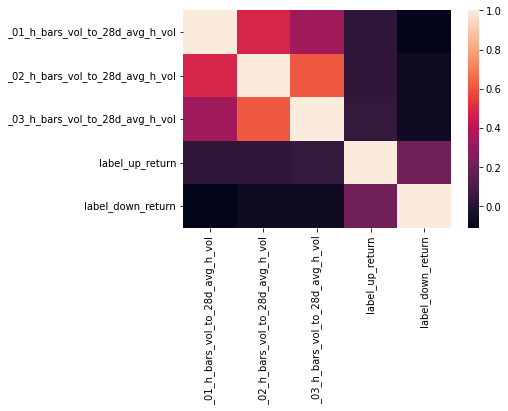

In [176]:
df['_01_h_bars_vol_to_28d_avg_h_vol'] = df['current_hour_bars_01_volume'] / df['history_statsMap_-28_days_avg1HourVolume']
df['_02_h_bars_vol_to_28d_avg_h_vol'] = df['current_hour_bars_02_volume'] / df['history_statsMap_-28_days_avg1HourVolume']
df['_03_h_bars_vol_to_28d_avg_h_vol'] = df['current_hour_bars_03_volume'] / df['history_statsMap_-28_days_avg1HourVolume']
df_volume_on_previous_as_coef = df[['_01_h_bars_vol_to_28d_avg_h_vol',
    '_02_h_bars_vol_to_28d_avg_h_vol',
    '_03_h_bars_vol_to_28d_avg_h_vol',
    'label_up_return', 'label_down_return']]
sns.heatmap(df_volume_on_previous_as_coef.corr())

<AxesSubplot:>

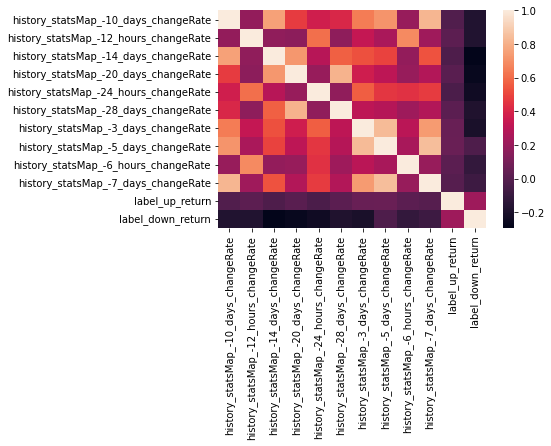

In [177]:
history_change_rate_cols = [c for c in df.columns if str(c).startswith('history_statsMap_-') and str(c).endswith('changeRate')]
df_history_change_rate = df[[*history_change_rate_cols, 'label_up_return', 'label_down_return']]
sns.heatmap(df_history_change_rate.corr())

In [178]:
df_vol_coef_clean[df_vol_coef_clean['current_h_vol_to_5_days_avg'] == df_vol_coef_clean['current_h_vol_to_5_days_avg'].max()]

,current_h_vol_to_10_days_avg,current_h_vol_to_12_hours_avg,current_h_vol_to_14_days_avg,current_h_vol_to_20_days_avg,current_h_vol_to_24_hours_avg,current_h_vol_to_28_days_avg,current_h_vol_to_3_days_avg,current_h_vol_to_5_days_avg,current_h_vol_to_6_hours_avg,current_h_vol_to_7_days_avg,label_up_return,label_down_return
2015,11.374771,18.041272,10.218787,11.201808,22.423708,9.882929,21.052797,20.78512,22.358444,15.534331,13.082205,0.0


In [179]:
with_cat = df
with_cat['up_return'] = pd.cut(df['label_up_return'], 
                               bins=[0, 30, 40, 50, 70, 100, 300, float('Inf')], 
                               labels=['0-30', '30-40', '40-50', '50-70', '70-100', '100-300', '300+'])

In [180]:
with_cat['down_return'] = pd.cut(df['label_down_return'],
                                 bins=[float('-Inf'), -30, -20, -10, 0], 
                                 labels=['-30', '-30-20', '-20-10', '-10-0'])

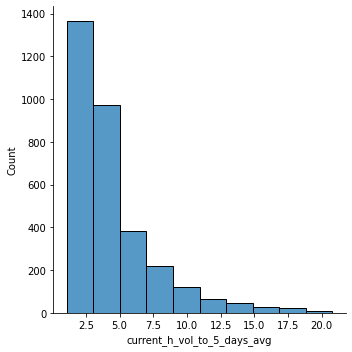

In [181]:
sns.displot(df_vol_coef_clean, x='current_h_vol_to_5_days_avg', bins=10)

<AxesSubplot:xlabel='up_return', ylabel='current_hour_bars_01_volume'>

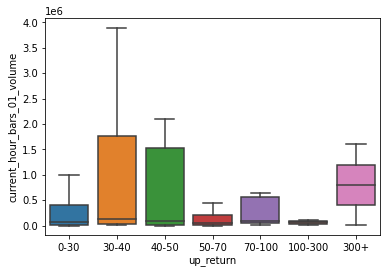

In [182]:
sns.boxplot(x = 'up_return', y = 'current_hour_bars_01_volume', data = with_cat, showfliers = False) 

<AxesSubplot:xlabel='up_return', ylabel='current_hour_bars_02_volume'>

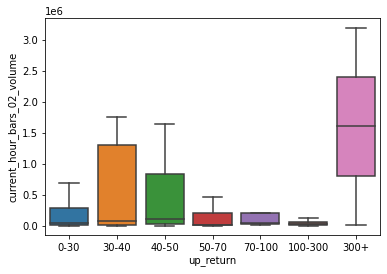

In [183]:
sns.boxplot(x = 'up_return', y = 'current_hour_bars_02_volume', data = with_cat, showfliers = False) 

<AxesSubplot:xlabel='up_return', ylabel='current_hour_bars_03_volume'>

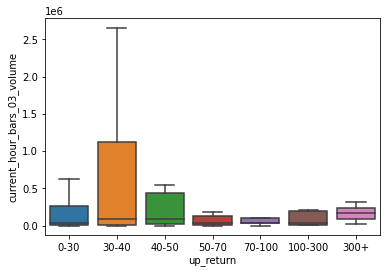

In [184]:
sns.boxplot(x = 'up_return', y = 'current_hour_bars_03_volume', data = with_cat, showfliers = False) 

<AxesSubplot:xlabel='up_return', ylabel='change_since_01_hour_bars'>

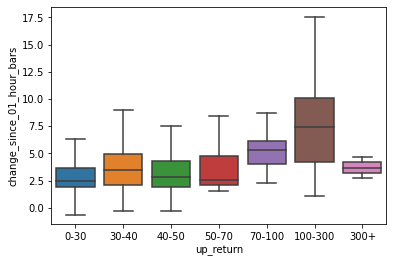

In [185]:
sns.boxplot(x = 'up_return', y = 'change_since_01_hour_bars', data = with_cat, showfliers = False) 

<AxesSubplot:xlabel='up_return', ylabel='change_since_02_hour_bars'>

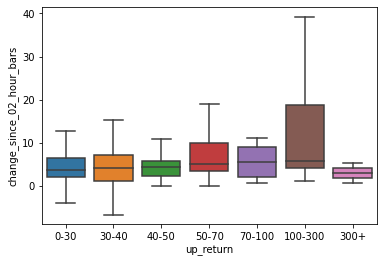

In [186]:
sns.boxplot(x = 'up_return', y = 'change_since_02_hour_bars', data = with_cat, showfliers = False) 

<AxesSubplot:xlabel='up_return', ylabel='change_since_03_hour_bars'>

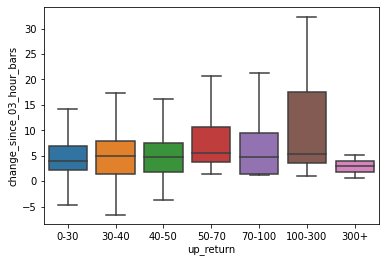

In [187]:
sns.boxplot(x = 'up_return', y = 'change_since_03_hour_bars', data = with_cat, showfliers = False) 

<AxesSubplot:xlabel='down_return', ylabel='change_since_01_hour_bars'>

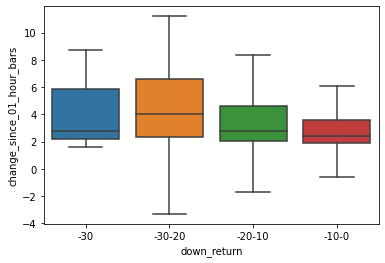

In [188]:
sns.boxplot(x = 'down_return', y = 'change_since_01_hour_bars', data = with_cat, showfliers = False) 

<AxesSubplot:xlabel='down_return', ylabel='change_since_02_hour_bars'>

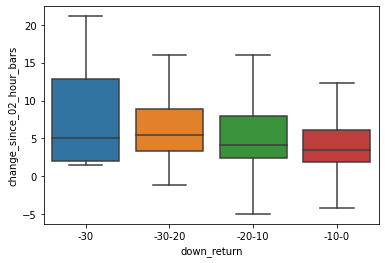

In [189]:
sns.boxplot(x = 'down_return', y = 'change_since_02_hour_bars', data = with_cat, showfliers = False) 

<AxesSubplot:xlabel='down_return', ylabel='change_since_03_hour_bars'>

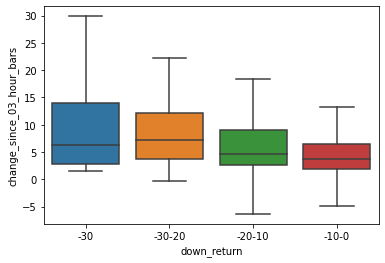

In [190]:
sns.boxplot(x = 'down_return', y = 'change_since_03_hour_bars', data = with_cat, showfliers = False) 

<AxesSubplot:xlabel='up_return', ylabel='current_h_vol_to_5_days_avg'>

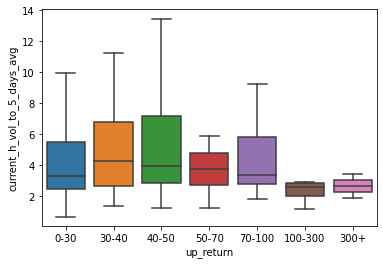

In [191]:
sns.boxplot(x = 'up_return', y = 'current_h_vol_to_5_days_avg', data = with_cat, showfliers = False) 

<AxesSubplot:xlabel='up_return', ylabel='current_h_vol_to_14_days_avg'>

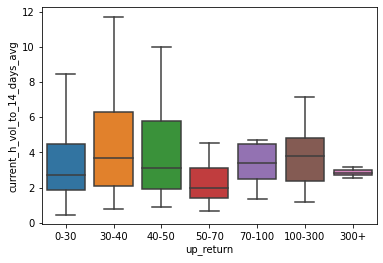

In [192]:
sns.boxplot(x = 'up_return', y = 'current_h_vol_to_14_days_avg', data = with_cat, showfliers = False) 

<AxesSubplot:xlabel='up_return', ylabel='current_h_vol_to_28_days_avg'>

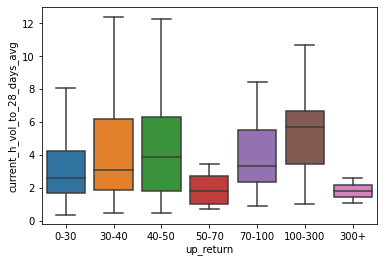

In [193]:
sns.boxplot(x = 'up_return', y = 'current_h_vol_to_28_days_avg', data = with_cat, showfliers = False) 

<AxesSubplot:xlabel='down_return', ylabel='current_h_vol_to_5_days_avg'>

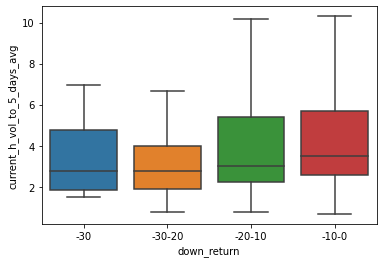

In [194]:
sns.boxplot(x = 'down_return', y = 'current_h_vol_to_5_days_avg', data = with_cat, showfliers = False) 

<AxesSubplot:xlabel='down_return', ylabel='current_h_vol_to_28_days_avg'>

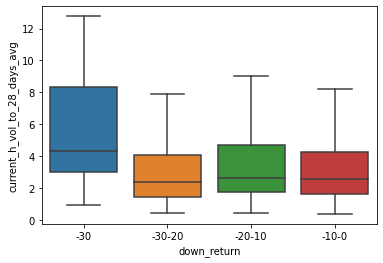

In [195]:
sns.boxplot(x = 'down_return', y = 'current_h_vol_to_28_days_avg', data = with_cat, showfliers = False) 

In [196]:
df_vol_coef_clean.nlargest(n=20, columns=['current_h_vol_to_5_days_avg'], keep='all')

,current_h_vol_to_10_days_avg,current_h_vol_to_12_hours_avg,current_h_vol_to_14_days_avg,current_h_vol_to_20_days_avg,current_h_vol_to_24_hours_avg,current_h_vol_to_28_days_avg,current_h_vol_to_3_days_avg,current_h_vol_to_5_days_avg,current_h_vol_to_6_hours_avg,current_h_vol_to_7_days_avg,label_up_return,label_down_return
2015,11.374771,18.041272,10.218787,11.201808,22.423708,9.882929,21.052797,20.785120,22.358444,15.534331,13.082205,0.000000
1491,2.902416,13.998713,3.071586,2.238131,16.097167,2.987885,22.799236,20.746494,8.831926,3.370751,7.371923,-2.979615
1462,2.842144,13.708013,3.007801,2.191653,15.762890,2.925838,22.325783,20.315669,8.648521,3.300753,11.255599,-0.591414
...,...,...,...,...,...,...,...,...,...,...,...,...
3899,16.740002,19.696747,15.389275,8.111125,12.543806,8.935644,16.657080,17.872852,13.347312,18.221426,0.000000,-7.918969
3616,15.055668,17.949991,13.917128,13.924736,14.295520,11.059859,18.818332,17.862630,10.810417,15.263509,2.543396,-0.928277
1253,14.671537,7.012107,11.020970,10.016973,6.536684,10.475576,15.575778,17.742692,5.181543,15.534708,5.517394,-4.985597


In [197]:
# 10 largest by up return
df_vol_coef_clean.nlargest(n=20, columns=['label_up_return'], keep='all')

,current_h_vol_to_10_days_avg,current_h_vol_to_12_hours_avg,current_h_vol_to_14_days_avg,current_h_vol_to_20_days_avg,current_h_vol_to_24_hours_avg,current_h_vol_to_28_days_avg,current_h_vol_to_3_days_avg,current_h_vol_to_5_days_avg,current_h_vol_to_6_hours_avg,current_h_vol_to_7_days_avg,label_up_return,label_down_return
4289,2.730959,4.959621,2.548087,1.907354,6.517344,1.066548,2.593224,3.444157,15.510234,3.297341,463.576159,-3.973510
3565,2.788568,2.047346,3.166093,3.310783,3.121304,2.570222,1.360199,1.895192,1.457558,2.303244,352.466368,-0.683323
3587,6.296841,4.573949,7.146197,7.772247,6.407179,5.857833,3.049384,4.258093,7.343440,5.181610,260.173381,-0.798912
...,...,...,...,...,...,...,...,...,...,...,...,...
804,3.211305,1.472969,3.420094,3.561484,2.418688,3.328178,3.453993,2.757373,3.208844,2.868850,89.158163,0.000000
805,3.211305,1.472969,3.420094,3.561484,2.418688,3.328178,3.453993,2.757373,3.208844,2.868850,89.158163,0.000000
2437,1.608349,2.017227,1.591573,1.071211,3.360605,1.394415,4.155298,3.704217,1.428474,3.590505,88.642857,-1.857143


In [198]:
# 10 smallest by down return
df_vol_coef_clean.nsmallest(n=20, columns=['label_down_return'], keep='all')

,current_h_vol_to_10_days_avg,current_h_vol_to_12_hours_avg,current_h_vol_to_14_days_avg,current_h_vol_to_20_days_avg,current_h_vol_to_24_hours_avg,current_h_vol_to_28_days_avg,current_h_vol_to_3_days_avg,current_h_vol_to_5_days_avg,current_h_vol_to_6_hours_avg,current_h_vol_to_7_days_avg,label_up_return,label_down_return
4063,14.701662,4.783774,12.982899,9.494937,5.925778,12.767263,5.955142,9.258272,10.319287,11.776623,73.604229,-40.634291
176,2.557623,2.856948,2.865956,3.662129,3.011488,4.440074,2.415343,2.388778,3.334724,2.481615,1.517241,-37.586207
4043,4.811692,1.565676,4.249159,3.107588,1.939442,4.178584,1.949052,3.030130,3.377389,3.854359,85.820368,-36.456860
...,...,...,...,...,...,...,...,...,...,...,...,...
46,1.845692,5.002208,2.493819,2.572125,5.649667,1.699642,1.850520,2.310014,16.440001,2.656520,6.662056,-27.063163
389,1.235531,2.573522,1.081022,1.378811,2.896487,1.626767,2.123417,1.664129,2.830170,1.389577,5.439392,-26.724180
1778,1.447893,2.568584,1.760825,2.073219,2.155609,2.608905,1.241168,1.230106,3.248073,1.370249,10.000000,-26.666667


In [199]:
# for c in  history_vol_cols:
#     sns.displot(df_vol_coef_clean[c], stat = 'density', binwidth=3)

In [200]:
#list(df.columns)

In [201]:
from data.scalers import min_max_scaler, standard_scaler


In [202]:
df = df.drop(['up_return', 'down_return'], axis=1)
df_norm = min_max_scaler(df)
df_std= standard_scaler(df)
##%%
#corr = df.corr()['label_up_return']
##%%
#pd.set_option('display.max_rows', None)  # or 1000
#abs(corr).sort_values(ascending=False)
##%%
#pd.set_option('display.max_rows', 10)  # or 1000

In [203]:
label_cols = ['label_up_return', 'label_down_return']
x = df.drop(label_cols, axis=1)
y_up = df['label_up_return']
y_down = df['label_down_return']

x_norm = df_norm.drop(label_cols, axis=1)
y_up_norm = df_norm['label_up_return']
y_down_norm = df_norm['label_down_return']

x_std = df_std.drop(label_cols, axis=1)
y_up_std = df_std['label_up_return']
y_down_std = df_std['label_down_return']

In [204]:
# EDA using SWEETVIZ automl library
#import sweetviz as sv
#sv_report = sv.analyze(df, pairwise_analysis='off')
#sv_report.show_html("sv.html")

In [205]:
from model_factory import ModelFactory
_, y_up_class = ModelFactory.prepare_classification_label(df, 20)
y_up_class.value_counts()

label_20_up
0              3100
1               430
dtype: int64

In [206]:
_, y_down_class = ModelFactory.prepare_classification_label(df, -10)
y_down_class.value_counts()

label_-10_down
1                 2606
0                  924
dtype: int64

In [207]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def train_random_forest_clasifier(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
    rfc = RandomForestClassifier()
    rfc.fit(x_train, y_train)
    return x_train, x_test, y_train, y_test, rfc

In [208]:
def train_logistic_regression_clasifier(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
    from sklearn.linear_model import LogisticRegression
    rfc = LogisticRegression(max_iter=5000, penalty="l2")
    rfc.fit(x_train, y_train)
    return x_train, x_test, y_train, y_test, rfc

In [209]:
x_up_class, x_up_test_class, y_train_up_class, y_up_test_class, up_random_forest_model = train_random_forest_clasifier(x, y_up_class)

C:\Users\hustlestar\AppData\Local\Temp\ipykernel_2412\605387943.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(x_train, y_train)


In [210]:
def eval_model(x_up_class, x_up_test_class, y_up_class, y_up_test_class, up_random_forest_model):
    # Make predictions for the test UP set
    y_up_predictions = up_random_forest_model.predict(x_up_test_class)
    # View accuracy score
    print(accuracy_score(y_up_test_class, y_up_predictions))
    
    # View confusion matrix for test data and predictions
    matrix = confusion_matrix(y_up_test_class, y_up_predictions)
    print(matrix)
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    
    # Build the plot
    plt.figure(figsize=(16,7))
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10},
                cmap=plt.cm.Greens, linewidths=0.2)
    
    # Add labels to the plot
    class_names = ['Higher than 20%', 'Lower Than 20%']
    tick_marks = np.arange(len(class_names))
    tick_marks2 = tick_marks + 0.5
    plt.xticks(tick_marks, class_names, rotation=25)
    plt.yticks(tick_marks2, class_names, rotation=0)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix for Random Forest Model')
    plt.show()
    # View the classification report for test data and predictions
    print(classification_report(y_up_test_class, y_up_predictions))
    

0.9575070821529745
[[307   3]
 [ 12  31]]


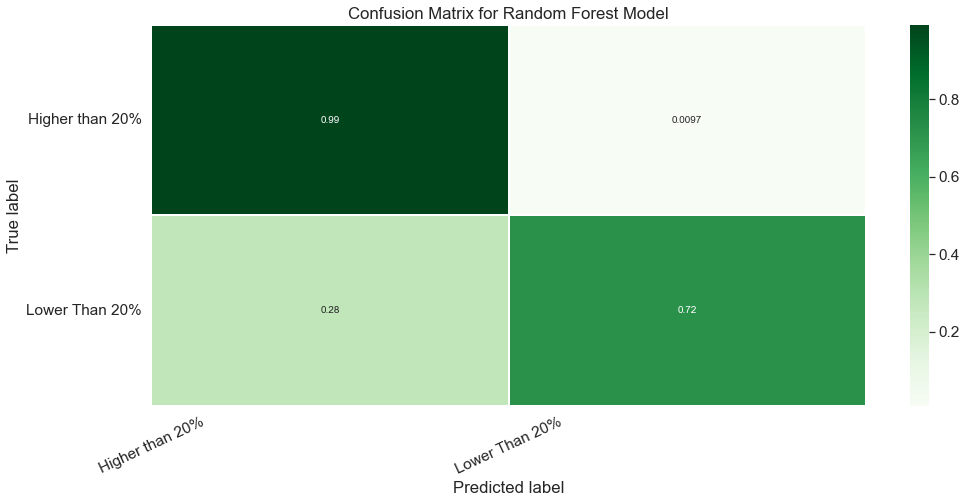

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       310
           1       0.91      0.72      0.81        43

    accuracy                           0.96       353
   macro avg       0.94      0.86      0.89       353
weighted avg       0.96      0.96      0.96       353



In [211]:
eval_model(x_up_class, x_up_test_class, y_train_up_class, y_up_test_class, up_random_forest_model)

IndexError: index 1 is out of bounds for axis 0 with size 1

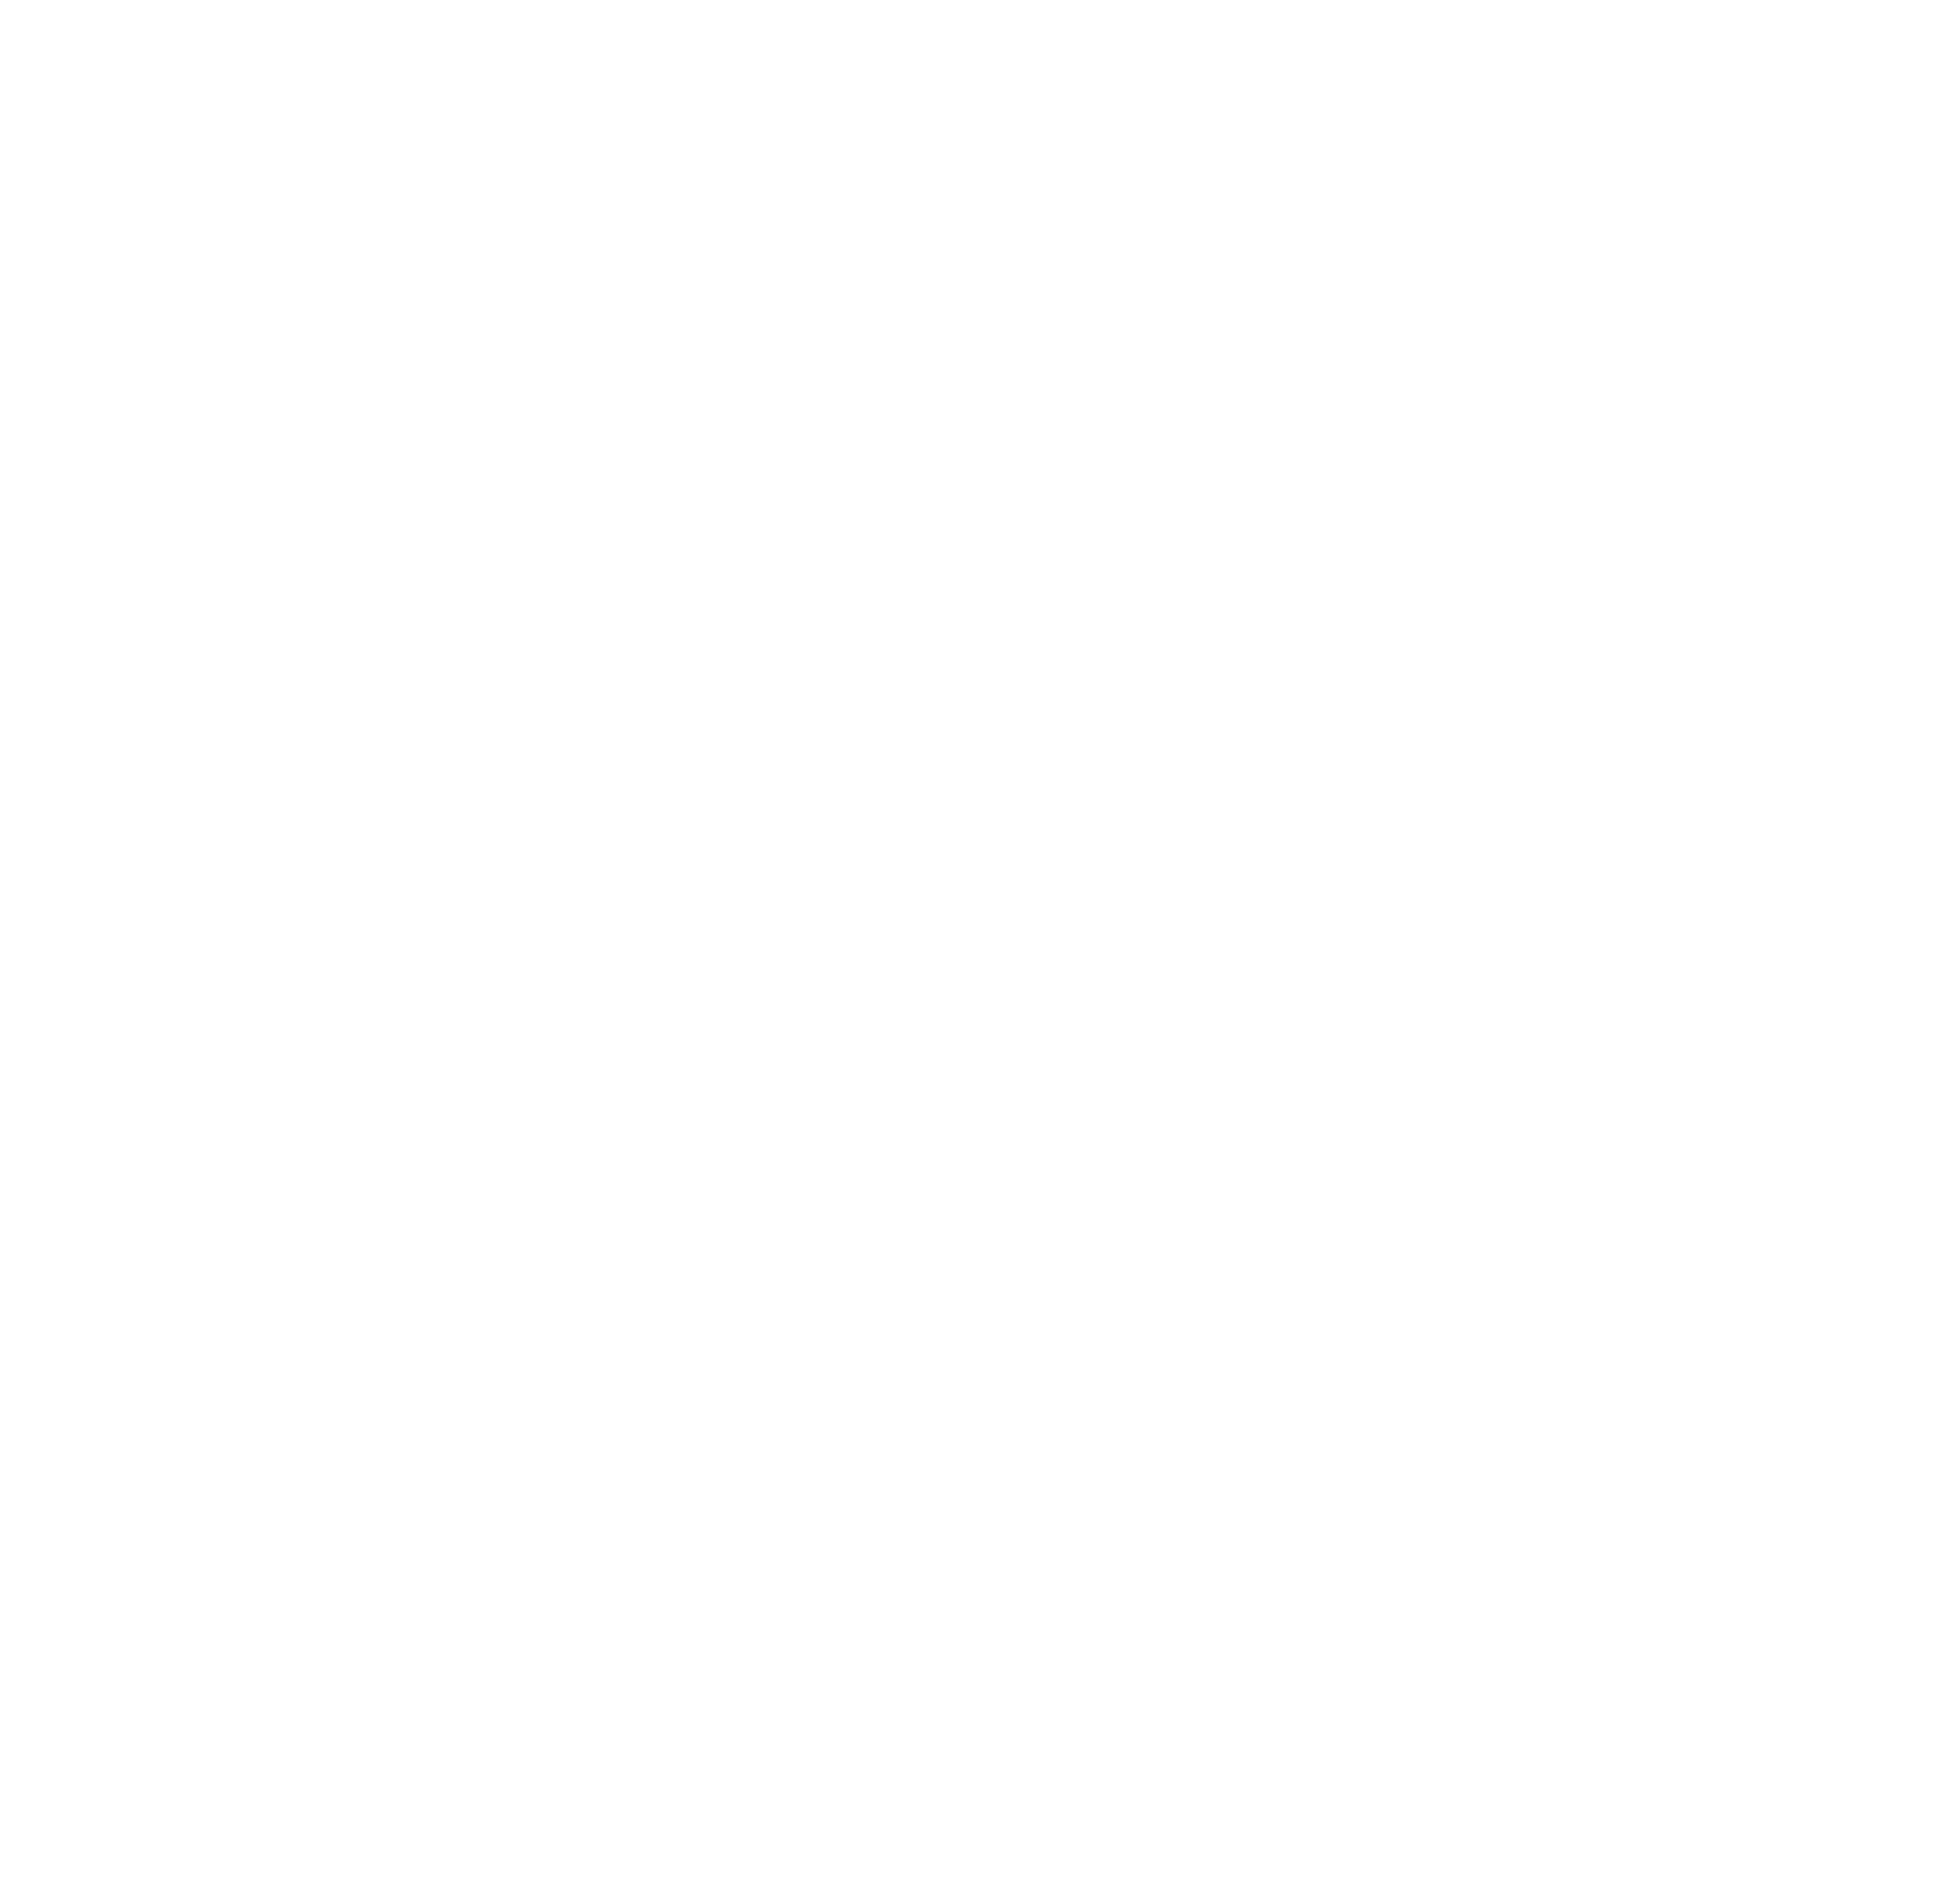

In [212]:
from sklearn.tree import export_graphviz
import os 
from sklearn import tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(up_random_forest_model.estimators_[0],
feature_names=x_up_class.columns,
class_names=y_train_up_class.columns,
filled=True,
rounded=True)
fig.savefig('rf_individualtree.png')

In [213]:
importances = up_random_forest_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in up_random_forest_model.estimators_], axis=0)


<AxesSubplot:>

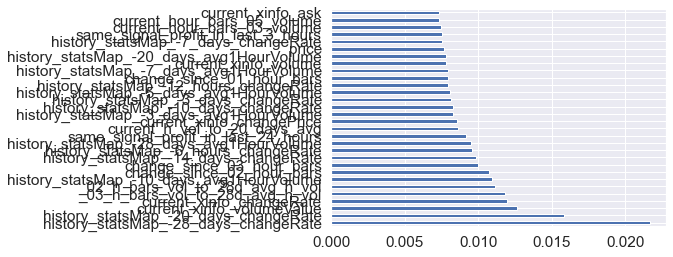

In [214]:
forest_importances = pd.Series(importances, index=x_up_class.columns)
forest_importances.nlargest(30).plot(kind='barh')

In [215]:
pd.set_option('display.max_rows', 50)  # or 1000

forest_importances.nlargest(50)

history_statsMap_-28_days_changeRate         0.021690
history_statsMap_-20_days_changeRate         0.015847
current_xinfo_volumeValue                    0.012642
current_xinfo_changeRate                     0.011942
_03_h_bars_vol_to_28d_avg_h_vol              0.011827
_02_h_bars_vol_to_28d_avg_h_vol              0.011112
history_statsMap_-10_days_avg1HourVolume     0.010892
change_since_02_hour_bars                    0.010747
change_since_03_hour_bars                    0.009960
history_statsMap_-14_days_changeRate         0.009801
history_statsMap_-6_hours_changeRate         0.009590
history_statsMap_-28_days_avg1HourVolume     0.009513
same_signal_profit_in_last_24_hours          0.009137
current_h_vol_to_20_days_avg                 0.008595
current_xinfo_changePrice                    0.008513
history_statsMap_-3_days_avg1HourVolume      0.008301
history_statsMap_-10_days_changeRate         0.008240
history_statsMap_-3_days_changeRate          0.008139
history_statsMap_-5_days_avg

C:\Users\hustlestar\Anaconda3\envs\x-dev\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9008498583569405
[[303  15]
 [ 20  15]]


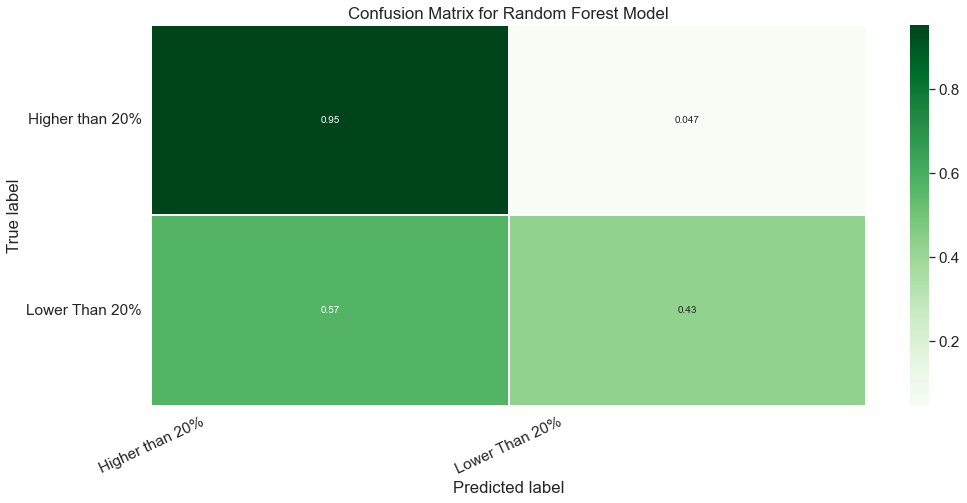

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       318
           1       0.50      0.43      0.46        35

    accuracy                           0.90       353
   macro avg       0.72      0.69      0.70       353
weighted avg       0.89      0.90      0.90       353



In [216]:
eval_model(*train_logistic_regression_clasifier(x_std, y_up_class))

In [217]:
x_down_class, x_down_test_class, y_down_train_class, y_down_test_class, down_random_forest_model = train_random_forest_clasifier(x, y_down_class)

C:\Users\hustlestar\AppData\Local\Temp\ipykernel_2412\605387943.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(x_train, y_train)


In [218]:
# Make predictions for the test DOWN set
y_down_predictions = down_random_forest_model.predict(x_down_test_class)
# View accuracy score
accuracy_score(y_down_test_class, y_down_predictions)

0.9263456090651558

In [219]:
# View confusion matrix for test data and predictions
matrix = confusion_matrix(y_down_test_class, y_down_predictions)
matrix

array([[ 84,  10],
       [ 16, 243]], dtype=int64)

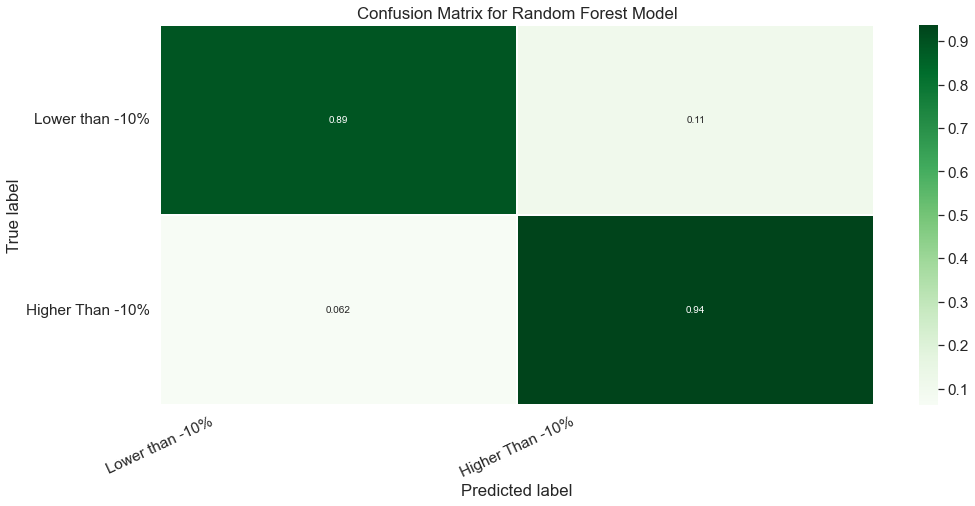

In [220]:
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Lower than -10%', 'Higher Than -10%']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [223]:
forest_importances = pd.Series(down_random_forest_model.feature_importances_, index=x_down_class.columns)
forest_importances.nlargest(50)

btc_stats_statsMap_-28_days_close              0.038886
current_xinfo_changeRate                       0.027694
btc_stats_statsMap_-5_days_avg1HourVolume      0.019206
btc_stats_statsMap_-7_days_avg1HourVolume      0.018881
btc_stats_statsMap_-24_hours_avg1HourVolume    0.018635
btc_stats_statsMap_-3_days_high                0.018074
change_since_03_hour_bars                      0.017964
btc_stats_statsMap_-6_hours_high               0.016644
btc_stats_statsMap_-6_hours_avg1HourVolume     0.016313
btc_stats_statsMap_-28_days_avg1HourVolume     0.015990
btc_stats_statsMap_-60_days_close              0.015742
change_since_01_hour_bars                      0.014129
change_since_02_hour_bars                      0.014052
btc_stats_statsMap_-14_days_changeRate         0.013731
btc_stats_statsMap_-28_days_changeRate         0.013396
btc_stats_statsMap_-12_hours_avg1HourVolume    0.013170
btc_stats_statsMap_-20_days_avg1HourVolume     0.011705
btc_stats_statsMap_-10_days_avg1HourVolume     0

In [ ]:
# View the classification report for test data and predictions
print(classification_report(y_down_test_class, y_down_predictions))

In [ ]:
# check stats using OLS from statsmodels
#import statsmodels.api as sm
#results = sm.OLS(y_up,x).fit()
#results.summary()

